# 521153S, Deep Learning assignment 3: Dataset and Convolutional Neural Networks



## Outline 
#### In this assignment, you will learn:
* Writing custom dataset in Pytorch with training, validation and testing data.
* Building a Convolutional Neural Network (CNN) in Pytorch.
* Training and testing your CNN in Pytorch.

#### Tasks (<span style="color:red">15 points or more</span>)
* **Part 1.** Writing a custom dataset based on [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist). Spliting the whole dataset into 3 parts: training, validation and testing. (<span style="color:red">5.5 points</span>)
    * 1.1. Define a Dataset class (<span style="color:red">2 points</span>)
    * 1.2. Dataset checking (<span style="color:red">2.5 points</span>)
    * 1.3. Iterating through the dataset with batches (<span style="color:red">1 points</span>)<br>
* **Part 2.** Build a CNN on your own. (<span style="color:red">3.5 points</span>) <br>
* **Part 3.** Train and test your CNN. (<span style="color:red">6 points or more</span>)
    * 3.1. Create functions for train and evaluation (<span style="color:red">2.5 points</span>) <br>
    * 3.2. Train and test your network (<span style="color:red">1.5 point</span>) <br>
    * 3.3. Modification for your training (<span style="color:red">1 point or more</span>) <br>
    * Question: give your ideas to accelerate your training process (<span style="color:red">1 points or more</span>)


#### Environment
Python 3, Numpy, matplotlib, torch, torchvision

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Here we are to split the 60,000 images in the predefined training set into a new training set with 50,000 images and a validation set with 10,000 images. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training, validation and testing splits. Using the Fashion-MNIST give you more room to wiggle your experiments.

#### Hints
* To find the place where you have to insert your solution, hit Crtl + F and search for **TODO:** . You are not supposed to modify the codes from other parts.
* Be careful with the shapes of the tensors flowing through the CNN model, making all the operations has compatible inputs and outputs. 

## Part 1. Writing a custom dataset with Pytorch (<span style="color:red">5.5 points</span>)
**Requirement**: Download the Fashion-MNIST dataset, which contains 60,000 images in the predefined training set and 10,000 images in the testing set. Our goal is to write a customer dataset that could be loaded by [torch.utils.data.DataLoader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#iterating-through-the-dataset). The 60,000 images in the predefined training set should be splited into a new training set and a validation set as mentioned above. ***Specifically, there are same number of images for each class both in the new training set and the validation set.*** I.e, in the new training set which has in total 10 classes and 50,000 image samples, each class has 5000 image samples while in the validation set, each class has 1000 samples.

### Part 1.1. Define a Dataset class (<span style="color:red">2 points</span>)
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit `torch.utils.data.Dataset` and override the following methods:
* `__len__` so that len(dataset) returns the size of the dataset.
* `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample

Let’s create a dataset class for our fashion MNIST dataset. We will download the dataset from google drive following Assignment2 firstly. Then, split the training set in `__init__`, return the size of this dataset in `__len__` and get each item in `__getitem__`. 

In [1]:
# import necessary packages
import os 
import torch 
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from download_fashion_mnist import download_fm
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms


# Download fashion_MNIST from google drive and creating indices for training and validation set
root_dir='data'
download_fm(root_dir)
      
data_dir = os.path.join(root_dir, 'fashion_mnist_npy')

train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))
train_label = np.load(os.path.join(data_dir, 'train_labels.npy'))
test_label = np.load(os.path.join(data_dir, 'test_labels.npy'))

# split the training data to a new training data and validation data
class_indices = [[] for i in range(10)]
for i, v in enumerate(train_label):
    class_indices[v].append(i)

indices_all = np.random.permutation(len(class_indices[0]))
# take the first 1000 indices of indices_all
indices = indices_all[:1000]
# take the rest of the indices of indices_all
indices_rest = indices_all[1000:]

valid_indices = []
train_indices = []
for i in range(10):
    # build indices for validation set
    valid_indices.extend(np.array(class_indices[i])[indices])
    # TODO: build indices for training set (0.5 points)
    train_indices.extend(np.array(class_indices[i])[indices_rest])

# write the custom dataset based on the downloaded data and the indices
class FashionMnist(Dataset):
    """Fashion Mnist dataset""" 

    def __init__(self, phase='train', transform=None):
        # download fashion_mnist data following Assignment2

        # TODO: now, split the predefined training data (1.5 points)
        if 'train' == phase:
            self.data = train_data[train_indices]
            self.label = train_label[train_indices]
        elif 'valid' == phase:
            self.data = train_data[valid_indices]
            self.label = train_label[valid_indices]
        elif 'test' == phase:
            self.data = test_data
            self.label = test_label
        else:
            assert True, 'wrong phase'
            

        self.transform = transform 
        
        self.label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        img, label = self.data[index], self.label[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

Data was already downloaded and extracted!


### Part 1.2. Dataset checking (<span style="color:red">2.5 points</span>)
First, randomly show some images in training, validation and testing data and check if the images have correct labels.<br>
Secondly, check the number of images for each class, to make sure the dataset created correctly.

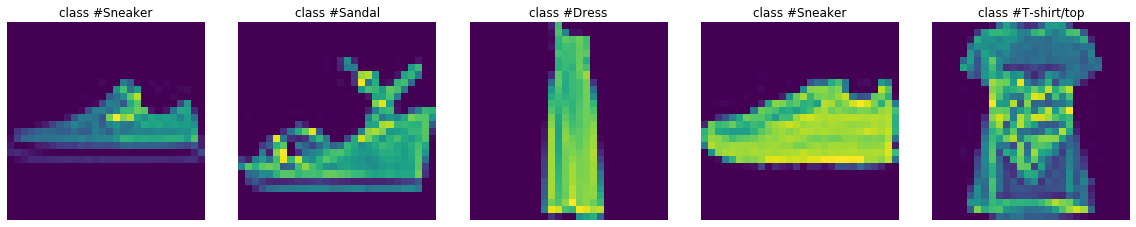

total number of training set: 50000
numer of images for class T-shirt/top: 5000
numer of images for class Trouser: 5000
numer of images for class Pullover: 5000
numer of images for class Dress: 5000
numer of images for class Coat: 5000
numer of images for class Sandal: 5000
numer of images for class Shirt: 5000
numer of images for class Sneaker: 5000
numer of images for class Bag: 5000
numer of images for class Ankle boot: 5000


In [2]:
# checking training set
# randomly show some samples and their labels
# TODO: create a FashionMnist dataset for training, set transform to None (0.5 points)
train_set =  FashionMnist(phase='train', transform=None)#this is the first 0.25 points, see the rest 0.25 points in Part 1.3
#train_set = FashionMnist(train = True, transform = None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_set)))
for i in range(10):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], np.sum(train_set.label==i)))

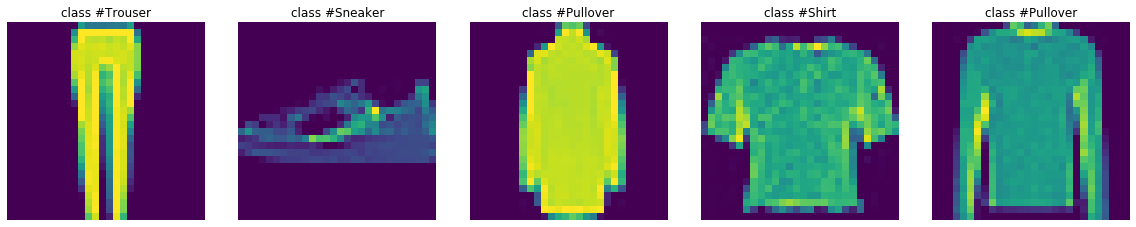

total number of validation set: 10000
numer of images for class T-shirt/top: 1000
numer of images for class Trouser: 1000
numer of images for class Pullover: 1000
numer of images for class Dress: 1000
numer of images for class Coat: 1000
numer of images for class Sandal: 1000
numer of images for class Shirt: 1000
numer of images for class Sneaker: 1000
numer of images for class Bag: 1000
numer of images for class Ankle boot: 1000


In [3]:
# TODO:checking validation data (1 points)
# randomly show some samples and their labels
# TODO: create a FashionMnist dataset for training, set transform to None (0.5 points)
valid_set =  FashionMnist(phase='valid', transform=None)#this is the first 0.25 points, see the rest 0.25 points in Part 1.3
#train_set = FashionMnist(train = True, transform = None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]
    label_name = valid_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of validation set: {}'.format(len(valid_set)))
for i in range(10):
    print('numer of images for class {}: {}'.format(valid_set.label_names[i], np.sum(valid_set.label==i)))

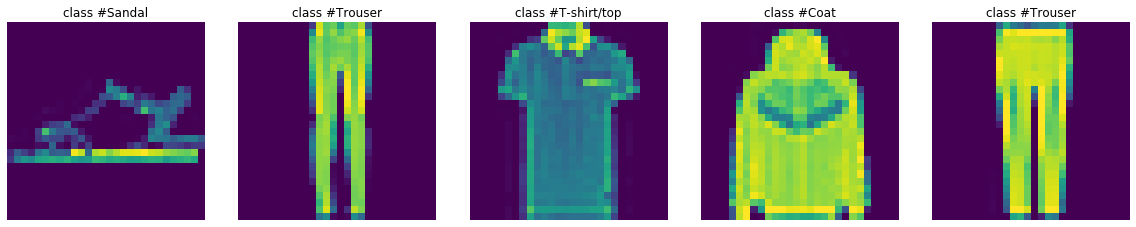

total number of testing set: 10000
numer of images for class T-shirt/top: 1000
numer of images for class Trouser: 1000
numer of images for class Pullover: 1000
numer of images for class Dress: 1000
numer of images for class Coat: 1000
numer of images for class Sandal: 1000
numer of images for class Shirt: 1000
numer of images for class Sneaker: 1000
numer of images for class Bag: 1000
numer of images for class Ankle boot: 1000


In [4]:
# TODO: checking testing data (1 points)
# randomly show some samples and their labels
# TODO: create a FashionMnist dataset for training, set transform to None (0.5 points)
test_set =  FashionMnist(phase='test', transform=None)#this is the first 0.25 points, see the rest 0.25 points in Part 1.3
#train_set = FashionMnist(train = True, transform = None)

num_to_show = 5
idx = np.random.choice(range(len(test_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = test_set[idx[i]]
    label_name = test_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of testing set: {}'.format(len(test_set)))
for i in range(10):
    print('numer of images for class {}: {}'.format(test_set.label_names[i], np.sum(test_set.label==i)))

### Part 1.3. Iterating through the dataset with batches (<span style="color:red">1 points</span>)
Here, we add more features with the help of [DataLoader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#iterating-through-the-dataset):
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

The `DataLoader` takes as input an instance of `FashionMnist` we defined in Part 1.1. Since images in the dataset currently are all in PIL format, we have to convert them to torch.Tensor by using a transform. Actually, `transform` is often used for data augmentation, further illustrations of `transform` can be found in [https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms).

In [5]:
# Set batch_size to 64, shuffling the training set and use 2 workers to do parallel reading.
data_transform = transforms.Compose([transforms.ToTensor()])
#data_transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor()])

train_set =  FashionMnist(phase='train', transform=data_transform)#the other 0.25 points for creating a FashionMnist dataset for training
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)

# TODO: create test_loader and valid_loader with no shuffling (1 points)
test_set =  FashionMnist(phase='test', transform=data_transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

valid_set =  FashionMnist(phase='valid', transform=data_transform)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0)

## Part 2. Build a CNN on your own (<span style="color:red">3.5 points</span>)
Structure of the CNN (**Conv**: convolutional layer, **BN**: Batch Normalization layer, **Max_Pool**: max pooling layer, **FC**: fully connected layer, batch_size=64):
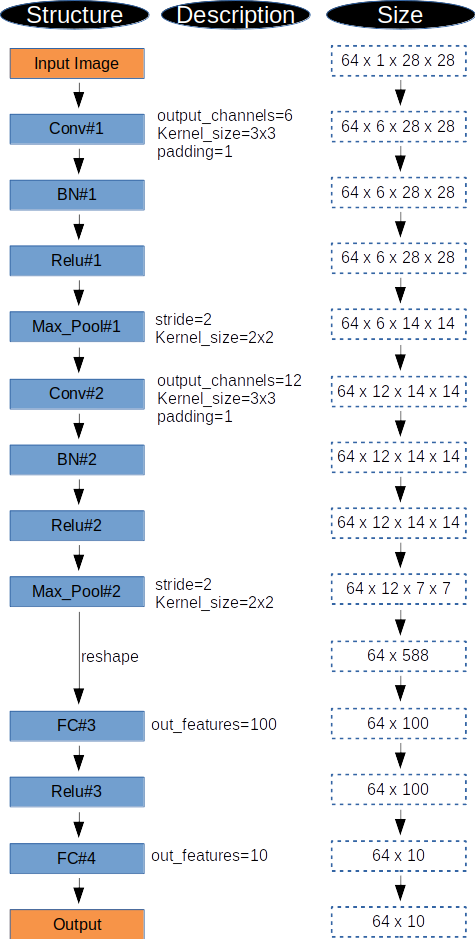

To define your own Network, following the rule of thumb:
1. Define the layers in `__init__`.
2. Do the forward calculation in `forward`.

In [57]:
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 

        # define layers 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # TODO: fill the rest part (1.5 points)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ### TEST ###
        #self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1)
        #self.bn3 = nn.BatchNorm2d(24)
        #self.relu3 = nn.ReLU()
        #self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #self.fc3 = nn.Linear(in_features=15000, out_features=100)
        #self.relu4 = nn.ReLU()
        #self.fc4 = nn.Linear(in_features=100, out_features=10)
        ### TEST - END ###
        
        ### Original ###
        self.fc3 = nn.Linear(in_features=588, out_features=100)    
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(in_features=100, out_features=50)
        
        ### EDIT +1 fc
        #self.fc5 =nn.Linear(in_features = 50, out_features = 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)     
        x = self.max_pool1(x)
        
        # TODO: fill the rest part, you may need more lines like x = ... (2 points)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        
        ### TEST
        #x = self.conv3(x)
        #x = self.bn3(x)
        #x = self.relu3(x)
        #x = self.max_pool3(x)
        
        x = x.reshape(x.shape[0], -1)

        x = self.fc3(x)
        x = self.relu3(x) #to be 3
        x = self.fc4(x)
        #x = self.fc5(x)

        return x
    

## Part 3. Train and test your CNN model (<span style="color:red">6 points or more</span>)
### Part 3.1. Create functions for train and evaluation (<span style="color:red">2.5 points</span>)
* Instantiate a network.
* When training, create an optimizer to take care of network's parameters, calculate the loss and accuracy.
* When evaluation, only need to claculate the accuracy.

In [62]:
# instantiate a network
net = Network(num_classes=10)

# evaluation function
def eval(net, data_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        outs = net(images) 
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(net, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9, no weight decay (0.5 points)
    optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) #fill the blank bracket
    #optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9, weight_decay=0)
    #optimizer= optim.Adam(net.parameters(), lr = 0.01)

    epoches = 10
    #epoches = 15
    for epoch in range(epoches):
        net.train() 
        correct = 0.0
        num_images = 0.0
        for i_batch, (images, labels) in enumerate(train_loader):
            # TODO: fill these blanks (0.5 points)
            outs = net(images) 
            loss = loss_function(outs, labels) 
            _, preds = outs.max(1)
            correct += preds.eq(labels).sum()
            num_images += len(labels)

            
            # TODO: clear grads (0.5 points)
            optimizer.zero_grad()
            
            # TODO: backward propogation (0.5 points)
            loss.backward()
            
            # TODO: update parameters (0.5 points)
            optimizer.step()

        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return net

### Part 3.2. Train and test your network (<span style="color:red">1.5 points</span>)

In [63]:
print('Please wait patiently, it may take some seconds...')
# TODO: train your network here (0.75 points)
net = train(net, train_loader, valid_loader)
# TODO: test your network here on testing data (0.75 points)
acc_test = eval(net, test_loader)
print('accuracy on testing data: %f' % acc_test)

Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.010000, accuracy: 0.823880, loss: 0.483165, valid accuracy: 0.875600
epoch: 1, lr: 0.010000, accuracy: 0.881480, loss: 1.038530, valid accuracy: 0.884400
epoch: 2, lr: 0.010000, accuracy: 0.895000, loss: 0.135958, valid accuracy: 0.900300
epoch: 3, lr: 0.010000, accuracy: 0.905140, loss: 0.384172, valid accuracy: 0.904600
epoch: 4, lr: 0.010000, accuracy: 0.911760, loss: 0.071433, valid accuracy: 0.909800
epoch: 5, lr: 0.010000, accuracy: 0.915120, loss: 0.079560, valid accuracy: 0.900000
epoch: 6, lr: 0.010000, accuracy: 0.919160, loss: 0.066870, valid accuracy: 0.907900
epoch: 7, lr: 0.010000, accuracy: 0.926660, loss: 0.130976, valid accuracy: 0.911600
epoch: 8, lr: 0.010000, accuracy: 0.930200, loss: 0.121768, valid accuracy: 0.915700
epoch: 9, lr: 0.010000, accuracy: 0.933340, loss: 0.113174, valid accuracy: 0.905900
accuracy on testing data: 0.899300


### Part 3.3. Modification for your training (<span style="color:red">1 points or more</span>)
Try the following tips to improve your network's performance:
* Weight decay? (Please set a weight penalty in optimizer)
* More epoches? 
* Data augmentation? (e.g., use [transforms.RandomHorizontalFlip](https://www.programcreek.com/python/example/104837/torchvision.transforms.RandomHorizontalFlip) when composing a transform)
* Maybe more convolutinal or fc layers? 
* Maybe use a shortcut in the convoluctional layer? (Refer to this [blog](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035))

**Note**: Each tip has 0.5 points, more tips used, more points you will get. You could come up with your own tips, and they should be reasonable, persuasive and implemented with your code.

In [ ]:
#Results are always taken at the last epoche

>>> Weight decay:
    optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9, weight_decay=0)
Result: Acc: 93,1 % / Loss: 0,25 / valid acc: 90,0 % / test acc: 90,0%

>>> Increasing Epoch to 15
    epoches = 10
Result: Acc: 94,0 % / Loss: 0,17 / valid acc: 91,0 % / test acc: 90,0%
                
>>> Data augmentation (Horizontal Flip)                           
    data_transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor()])
Result: Acc: 92,0 % / Loss: 0,27 / valid acc: 91,0 % / test acc: 89,0%

>>> Adding +1 convolutinal layer
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(24)
    self.relu3 = nn.ReLU()
    self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)   
Result: Acc: 92,0 % / Loss: 0,30 / valid acc: 90,0 % / test acc: 89,0%

>>> Adding +1 fully connected layer (fc)
    self.fc5 =nn.Linear(in_features = 50, out_features = 10)
    x = self.fc5(x)
Result: Acc: 93,0 % / Loss: 0,24 / valid acc: 90,0 % / test acc: 89,0%

--------------------------------
=== Own Improvement Methodes === 
--------------------------------

>>> Using the optim.Adam method istead of the SGD as gradient descent method. 
    optimizer= optim.Adam(net.parameters(), lr = 0.01)
Result: Acc: 93,0 % / Loss: 0,03 / valid acc: 91,0 % / test acc: 89,0%
    
>>> Changing stride from 2 --> 1 in the layer definition
Result: Acc: 96,0 % / Loss: 0,05 / valid acc: 91,0 % / test acc: 90,0%

>>> Changing the kernal size from 3x3 to 5x5 in the layer definition
Result: Acc: 92,0 % / Loss: 0,18 / valid acc: 90,0 % / test acc: 89,0%
                    
>>> Combining multiple methodes: Changing stride from 2 --> 1 & set weight decay & adding +1 convolutinal layer
Result: Acc: 97,0 % / Loss: 0,08 / valid acc: 92,0 % / test acc: 91,0%

###  Question: give your ideas to accelerate your training process (<span style="color:red">1 points or more</span>)
#### Your answer: (the first two is 0.5 points each, the rest is 0.25 points each. More ideas, more points, with the upper limit 2 points in total. Ideas should be reasonable and persuasive.)

1) increasing the number of strides
2) increasing the batch size
3) Reducing the number of epoches
4) Using a short cut in the convolutinal layer (Using the ResNet). But becuase of the small number of layers in this model it's not really working out
5) increasing kernal size when defining the layers
6) removing one FC and making the one remaining FC output = 10